In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Datos de vacunación al día

In [25]:
primera = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_1eraDosis.csv')
segunda = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_2daDosis.csv')
unica = pd.read_csv('https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto78/vacunados_edad_fecha_UnicaDosis.csv')

#Uso Edad como índice y convierto todo a int
primera = primera.set_index('Edad').fillna(0).astype(int)
segunda = segunda.set_index('Edad').fillna(0).astype(int)
unica = unica.set_index('Edad').fillna(0).astype(int)

## Junto todos los vacunados >100 años bajo la edad 100
primera.loc[100] = primera.loc[100:].sum()
primera = primera.loc[:100]

segunda.loc[100] = segunda.loc[100:].sum()
segunda = segunda.loc[:100]

unica.loc[100] = unica.loc[100:].sum()
unica = unica.loc[:100]

primera_unica = primera + unica
segunda_unica = segunda + unica

dia_datos = pd.to_datetime(primera_unica.columns[-1]).strftime('%d/%m')

# Convierto formato de fechas
primera_unica.columns = pd.to_datetime(primera_unica.columns).strftime('%d/%m/%Y')
segunda_unica.columns = pd.to_datetime(segunda_unica.columns).strftime('%d/%m/%Y')

## Datos de Población

In [26]:
county_population_raw = pd.read_csv(
    "https://www.ine.cl/docs/default-source/proyecciones-de-poblacion/cuadros-estadisticos/base-2017/ine_estimaciones-y-proyecciones-de-poblaci%C3%B3n-1992-2050_base-2017_base-de-datos.csv",
    encoding='ISO-8859-1', sep=";", thousands='.')

#Extraigo datos del 2021 para ambos sexos, limpio nombres de columnas
Pob2021 = county_population_raw.iloc[1:102,[0,30]].rename({"POBLACIÓN TOTAL (AMBOS SEXOS)":"Edad", "Unnamed: 30": "Población"}, axis =1)

#El último valor, de mayores de 100 años será representado por 100, para mantener valores en formato int
Pob2021.iloc[100,0] = 100
Pob2021 = Pob2021.astype(int)

#Uso Edad como índice
Pob2021.set_index('Edad', inplace = True)

#Extraigo valores desde los 12 años, para coincidir con datos de vacunación
Pob12 = Pob2021.loc[12:100]

#Extraigo los totales de poblacion para luego utilizarlo para calcular % de Vacunad@s
Pob_total = Pob2021['Población'].sum()
Pob_12_total = Pob12['Población'].sum()

## Vacunad@s totales

In [27]:
#Construyo un DataFrame con los totales de vacunad@s por edad

total = pd.DataFrame()
total['Edad'] = primera_unica.index
total.set_index('Edad', inplace = True)
total['Población'] = Pob12['Población']
total['Primera Dosis'] = primera_unica.sum(axis = 1)
total['Segunda Dosis'] = segunda_unica.sum(axis = 1)
total['Sin Segunda Dosis'] = total['Primera Dosis'] - total['Segunda Dosis']
total.style.bar(['Primera Dosis','Segunda Dosis'], width = 98, color = 'lightblue', align = 'left')

,Población,Primera Dosis,Segunda Dosis,Sin Segunda Dosis
Edad,,,,
12,261239,26940,7628,19312
13,254675,29982,8146,21836
14,247390,100168,8775,91393
15,242698,156770,9556,147214
16,242620,183439,25917,157522
17,246540,190800,67274,123526
18,251565,211262,166990,44272
19,259382,208207,167717,40490
20,266643,218868,185399,33469


In [28]:
total.iloc[:,1:3].sum()

Primera Dosis    13819355
Segunda Dosis    12252722
dtype: int64

## Vacunad@s en relación a población

In [29]:
#Divido los totales por la población de cada edad
primera_unica_p = primera_unica.div(Pob12['Población'], axis = 'rows')
segunda_unica_p = segunda_unica.div(Pob12['Población'], axis = 'rows')
unica_p = unica.div(Pob12['Población'], axis = 'rows')

In [30]:
#Construyo DataFrame con los totales en relación a Población
total_p = pd.DataFrame()
total_p['Edad'] = primera_unica_p.index
total_p.set_index('Edad', inplace = True)
total_p['Población'] = Pob12['Población']
total_p['Primera Dosis'] = primera_unica_p.sum(axis = 1)*100
total_p['Segunda Dosis'] = segunda_unica_p.sum(axis = 1)*100
total_p['Sin Segunda Dosis'] = total_p['Primera Dosis'] - total_p['Segunda Dosis']

In [31]:
total_p.style.bar(['Primera Dosis','Segunda Dosis'], width = 98, color = 'lightblue', align = 'left').format({'Primera Dosis':'{:.1f} %', 'Segunda Dosis':'{:.1f} %'})

,Población,Primera Dosis,Segunda Dosis,Sin Segunda Dosis
Edad,,,,
12,261239,10.3 %,2.9 %,7.39246
13,254675,11.8 %,3.2 %,8.57406
14,247390,40.5 %,3.5 %,36.9429
15,242698,64.6 %,3.9 %,60.6573
16,242620,75.6 %,10.7 %,64.9254
17,246540,77.4 %,27.3 %,50.1038
18,251565,84.0 %,66.4 %,17.5986
19,259382,80.3 %,64.7 %,15.6102
20,266643,82.1 %,69.5 %,12.552


In [32]:
total.iloc[:,1:3].sum().div(Pob_total)

Primera Dosis    0.702261
Segunda Dosis    0.622649
dtype: float64

## Vacunación por grupo etario

In [33]:
def grupos(edad):
    if (edad >= 12) & (edad <= 17):
        return '12-17'
    elif (edad >= 18) & (edad <= 29):
        return '18-29'
    elif (edad >= 30) & (edad <= 39):
        return '30-39'
    elif (edad >= 40) & (edad <= 49):
        return '40-49'
    elif (edad >= 50) & (edad <= 59):
        return '50-59'
    elif (edad >= 60) & (edad <= 69):
        return '60-69'
    elif (edad >= 70) & (edad <= 79):
        return '70-79'
    else:
        return '80+'

total['Grupo'] = total.index.map(grupos)
total_grupos = total.groupby('Grupo').sum()

#Agrego columnas con %
total_grupos['Primera Dosis %'] = total_grupos['Primera Dosis']/total_grupos['Población']
total_grupos['Segunda Dosis %'] = total_grupos['Segunda Dosis']/total_grupos['Población']
total_grupos['Sin Segunda Dosis %'] = total_grupos['Sin Segunda Dosis']/total_grupos['Población']

In [34]:
total_grupos

,Población,Primera Dosis,Segunda Dosis,Sin Segunda Dosis,Primera Dosis %,Segunda Dosis %,Sin Segunda Dosis %
Grupo,,,,,,,
12-17,1495162,688099,127296,560803,0.460217,0.085139,0.375078
18-29,3556947,2863690,2394006,469684,0.805098,0.673051,0.132047
30-39,3120583,2593000,2335633,257367,0.830934,0.748460,0.082474
40-49,2658453,2276666,2124631,152035,0.856388,0.799198,0.057189
50-59,2392614,2227028,2161470,65558,0.930793,0.903393,0.027400
60-69,1857879,1701772,1666955,34817,0.915976,0.897236,0.018740
70-79,1046294,974507,958882,15625,0.931389,0.916456,0.014934
80+,568070,494593,483849,10744,0.870655,0.851742,0.018913


In [35]:
#Agrego dos lineas con los % de vacunados en relación a Población >12 años y Población total

total_grupos.loc['Población 12+', 'Segunda Dosis %'] = total_grupos['Segunda Dosis'].sum()/total_grupos['Población'].sum()
total_grupos.loc['Población 12+', 'Sin Segunda Dosis %'] = total_grupos['Sin Segunda Dosis'].sum()/total_grupos['Población'].sum()

total_grupos.loc['Pob Total', 'Segunda Dosis %'] = total_grupos.loc['Población 12+', 'Segunda Dosis %']*Pob_12_total/Pob_total
total_grupos.loc['Pob Total', 'Sin Segunda Dosis %'] = total_grupos.loc['Población 12+', 'Sin Segunda Dosis %']*Pob_12_total/Pob_total

#Columna para ordenar
total_grupos['sort'] = [0,0,0,0,0,0,0,0,1,2]
total_grupos.sort_values('sort', ascending=False, inplace=True)

#Extraigo solo los porcentajes
total_grupos_resumen = total_grupos.iloc[:,5:7]*100

In [36]:
total_grupos_resumen

,Segunda Dosis %,Sin Segunda Dosis %
Grupo,,
Pob Total,62.264946,7.961196
Población 12+,73.387162,9.383282
12-17,8.513860,37.507842
18-29,67.305079,13.204695
30-39,74.846046,8.247401
40-49,79.919826,5.718928
50-59,90.339269,2.740016
60-69,89.723550,1.874019
70-79,91.645560,1.493366


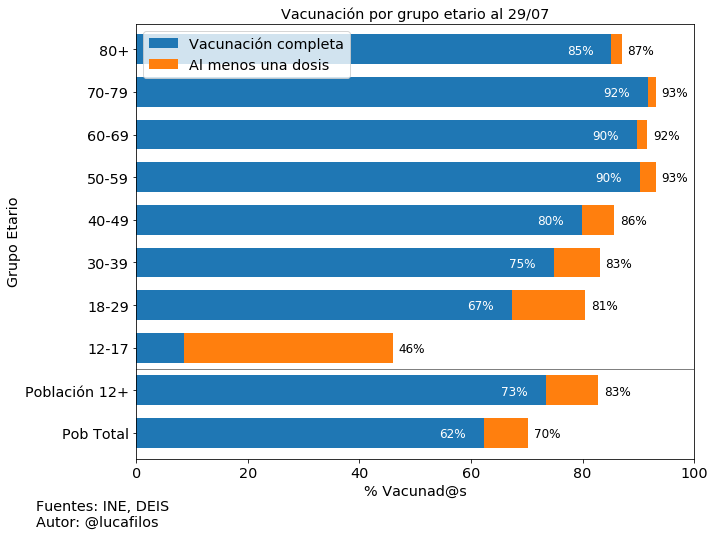

In [37]:
fig, ax = plt.subplots(figsize=(10,8))
total_grupos_resumen.plot(kind='barh', ax=ax, fontsize='x-large', stacked = True, width = 0.7)

for i, v in enumerate(total_grupos_resumen['Segunda Dosis %']):
    if v > 20:
        ax.text(v-8, i-.1, f'{v:.0f}%', color = 'white', fontsize = 'large')
    w = total_grupos_resumen.iloc[i, 1]
    ax.text(v+w+1, i-.1, f'{v+w:.0f}%', color = 'black', fontsize = 'large')


ax.set_title(f'Vacunación por grupo etario al {dia_datos}', fontsize='x-large')
ax.set_xlabel('% Vacunad@s', fontsize='x-large')
ax.set_ylabel('Grupo Etario', fontsize='x-large')
ax.legend(loc = 2, fontsize = 'x-large', labels = ('Vacunación completa', 'Al menos una dosis'))
plt.xlim(0,100)
plt.annotate('Fuentes: INE, DEIS\nAutor: @lucafilos', (0,0), (-100,-40), fontsize='x-large', xycoords='axes fraction', textcoords='offset points', va='top')
ax.axhline(1.5, color='grey', linewidth=1)

## Vacunación en el tiempo por grupo etario

In [38]:
primera_unica['Grupo'] = primera_unica.index.map(grupos)
segunda_unica['Grupo'] = segunda_unica.index.map(grupos)

primera_total_cp = primera_unica.iloc[:,:-1].sum().cumsum().div(Pob_total)
segunda_total_cp = segunda_unica.iloc[:,:-1].sum().cumsum().div(Pob_total)

primera_total12_cp = primera_unica.iloc[:,:-1].sum().cumsum().div(Pob_12_total)
segunda_total12_cp = segunda_unica.iloc[:,:-1].sum().cumsum().div(Pob_12_total)

In [39]:
# valores absolutos diarios
primera_fecha = primera_unica.groupby('Grupo').sum()
segunda_fecha = segunda_unica.groupby('Grupo').sum()

#valores absolutos acumulativos
primera_fecha_c = primera_unica.groupby('Grupo').sum().cumsum(axis = 1)
segunda_fecha_c = segunda_unica.groupby('Grupo').sum().cumsum(axis = 1)

#valores relativos diarios
primera_fecha_p = primera_unica.groupby('Grupo').sum().div(total_grupos['Población'], axis = 0)
segunda_fecha_p = segunda_unica.groupby('Grupo').sum().div(total_grupos['Población'], axis = 0)

#valores relativos acumualtivos
primera_fecha_cp = primera_unica.groupby('Grupo').sum().cumsum(axis = 1).div(total_grupos['Población'], axis = 0)
segunda_fecha_cp = segunda_unica.groupby('Grupo').sum().cumsum(axis = 1).div(total_grupos['Población'], axis = 0)

### Primera Dosis

Text(0.5, 1.0, 'Vacunación por grupo etario al 29/07')

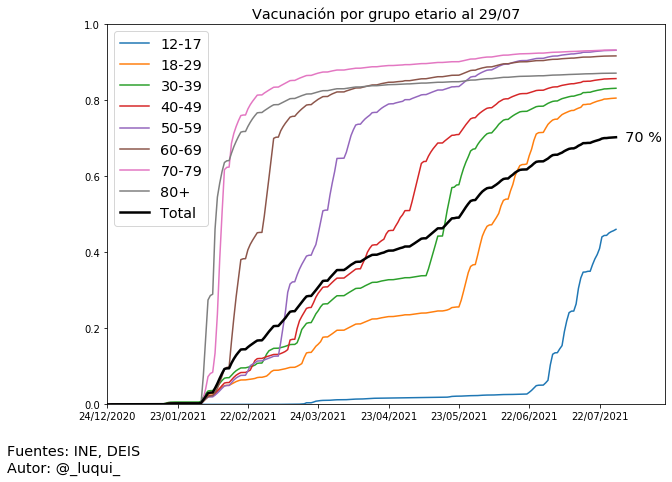

In [40]:
fig, ax = plt.subplots(figsize = (10,7))
primera_fecha_cp.iloc[:8,:].T.plot(ax=ax)
ax.plot(primera_total_cp, label = 'Total', color = 'black', lw=2.5)
ax.legend(fontsize = 'x-large')
ax.set_xticks(np.arange(0,len(primera.columns),30))
ax.set_xticklabels(primera_fecha_cp.columns[np.arange(0,len(primera.columns),30)])
ax.set_xlim(0,len(primera.columns)+20)
ax.set_ylim(0,1)
plt.annotate('Fuentes: INE, DEIS\nAutor: @_luqui_', (0,0), (-100,-40), fontsize='x-large', xycoords='axes fraction', textcoords='offset points', va='top')
ax.text(primera_total_cp.index[-1], primera_total_cp[-1]-.01,f'  {primera_total_cp[-1]*100:.0f} %',fontsize='x-large' )
ax.set_title(f'Vacunación por grupo etario al {dia_datos}', fontsize='x-large')


[Text(0, 0, '24/12/2020'),
 Text(0, 0, '23/01/2021'),
 Text(0, 0, '22/02/2021'),
 Text(0, 0, '24/03/2021'),
 Text(0, 0, '23/04/2021'),
 Text(0, 0, '23/05/2021'),
 Text(0, 0, '22/06/2021'),
 Text(0, 0, '22/07/2021')]

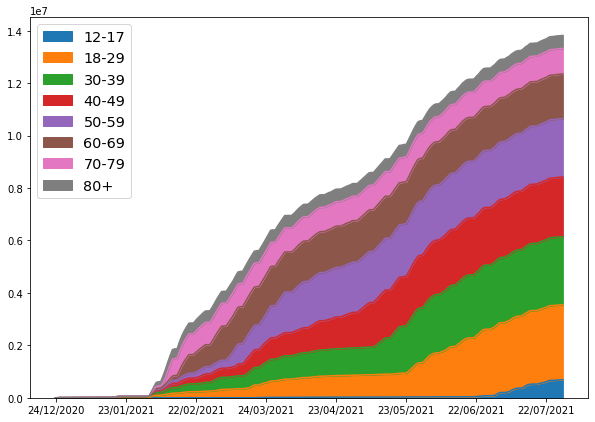

In [41]:
fig, ax = plt.subplots(figsize = (10,7))
primera_fecha_c.iloc[:8,:].T.plot(ax=ax, kind = 'area', stacked = True)
ax.legend(fontsize = 'x-large')
ax.set_xticks(np.arange(0,len(primera.columns),30))
ax.set_xticklabels(primera_fecha_c.columns[np.arange(0,len(primera.columns),30)])

### Segunda Dosis

Text(0.5, 1.0, 'Vacunación por grupo etario al 29/07')

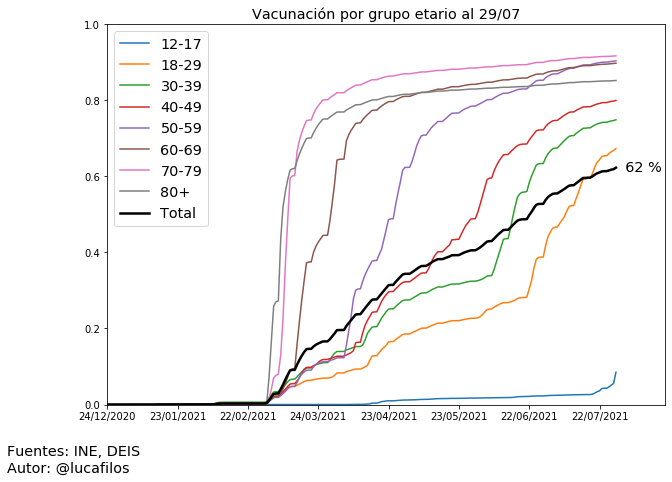

In [42]:
fig, ax = plt.subplots(figsize = (10,7))
segunda_fecha_cp.iloc[:8,:].T.plot(ax=ax)
ax.plot(segunda_total_cp, label = 'Total', color = 'black', lw=2.5)
ax.legend(fontsize = 'x-large')
ax.set_xticks(np.arange(0,len(segunda.columns),30))
ax.set_xticklabels(segunda_fecha_cp.columns[np.arange(0,len(segunda.columns),30)])
ax.set_ylim(0,1)
ax.set_xlim(0,len(segunda.columns)+20)
plt.annotate('Fuentes: INE, DEIS\nAutor: @lucafilos', (0,0), (-100,-40), fontsize='x-large', xycoords='axes fraction', textcoords='offset points', va='top')
ax.text(segunda_total_cp.index[-1], segunda_total_cp[-1]-.01,f'  {segunda_total_cp[-1]*100:.0f} %',fontsize='x-large' )
ax.set_title(f'Vacunación por grupo etario al {dia_datos}', fontsize='x-large')

[Text(0, 0, '24/12/2020'),
 Text(0, 0, '23/01/2021'),
 Text(0, 0, '22/02/2021'),
 Text(0, 0, '24/03/2021'),
 Text(0, 0, '23/04/2021'),
 Text(0, 0, '23/05/2021'),
 Text(0, 0, '22/06/2021'),
 Text(0, 0, '22/07/2021')]

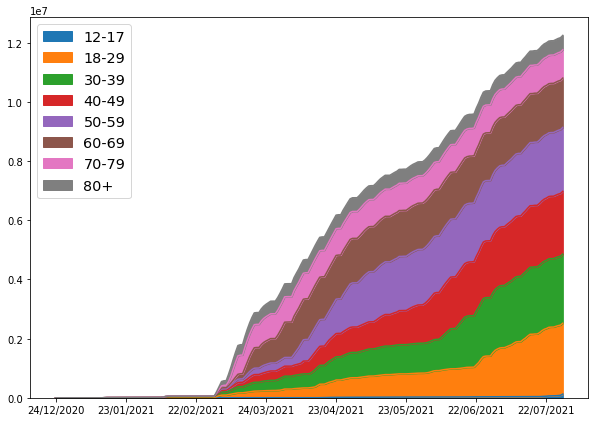

In [43]:
fig, ax = plt.subplots(figsize = (10,7))
segunda_fecha_c.iloc[:8,:].T.plot(ax=ax, kind = 'area', stacked = True)
ax.legend(fontsize = 'x-large')
ax.set_xticks(np.arange(0,len(segunda.columns),30))
ax.set_xticklabels(primera_fecha_c.columns[np.arange(0,len(segunda.columns),30)])